# Deep Switching Autoregresive Factorization (DSARF)

DSARF package is an easy-to-use implementation of our [AAAI'21 paper](https://arxiv.org/pdf/2009.05135.pdf) which can be used for training, testing, and visulization in just few lines of code ([check Documentation here](./Documentation.ipynb)). In this notebook, we show how to use DSARF for short- and long-term prediction and state estimation on several vector time series datasets.

In [1]:
from dsarf import DSARF
from dsarf import compute_NRMSE
import numpy as np
import torch
torch.manual_seed(10)
np.random.seed(10)

## Example 1: Bat Flight Dataset

The dataset is a list of $N=10$ skeletal data of size $(T=166-436)\times (D=34\times 3)$. We keep the last two data for test. We downsample data in time by a factor of 5.

In [91]:
import json
path = "./data/bat.json"
f = open(path)
data = json.load(f)
D = len(data['joints']) * 3
data = [np.array(data[key]).reshape(-1, D)[::5]
           for key in list(data.keys())[3:-2]]
data_train = data[:-2]
data_test = data[-2:]

After loading the dataset, we initilize the DSARF model with arguments `D: feature dimension of data`, `factor_dim: latent dimension`, `L: list of temporal lags`, `S: number of discrete states`. We set `batch_size = 1` as this dataset contains data with different temporal length. Alternatively, we could pad all the data with Nans to the same length and use a higher batch size.

In [92]:
dsarf = DSARF(D, factor_dim =5, L=[1,2], S=2, batch_size=1, recursive_state = True)

Now, we are ready to fit the train data on the model for 300 epochs. The model outputs ELBO loss each epoch, and reconstruction error and next-time-point prediction error every 50 epochs.

In [93]:
model_train = dsarf.fit(data_train, epoch_num = 300)

Using device: cpu
Total Number of Parameters: 9805
Learnable Parameters: 8397


  0%|          | 0/300 [00:00<?, ?it/s]

Once the model is trained, we can run inference on a test set.

In [94]:
model_test = dsarf.infer(data_test)

Using device: cpu
Total Number of Parameters: 3001
Learnable Parameters: 1524


  0%|          | 0/500 [00:00<?, ?it/s]

We can use the built-in function in the output model to plot states for few of the data instances (around 10 instances sampled at fixed intervals). We can access inferred states by calling `model.q_s` which returns a tensor of size $N\times T_{max}\times S$. 

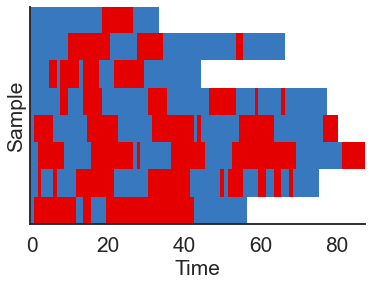

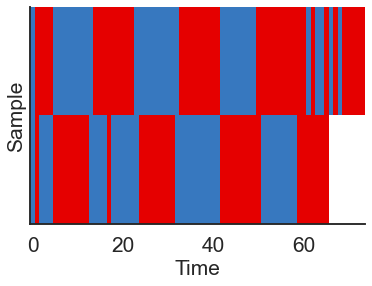

In [95]:
model_train.plot_states()
model_test.plot_states()

We can get the short-term predicted data by calling `y_pred, y_pred_n, y_pred_p = model.short_predict()`
which returns predicted data and their $\pm\sigma$ uncertainty intervals. We can simply plot short-term predicted vs groundtruth time series (for few intances and dimensions) by passing the grountruth data as input to the built-in function `model.plot_predict(data)` or call `model.report_stats(data)` to obtain reconstruction and short-term prediction error.

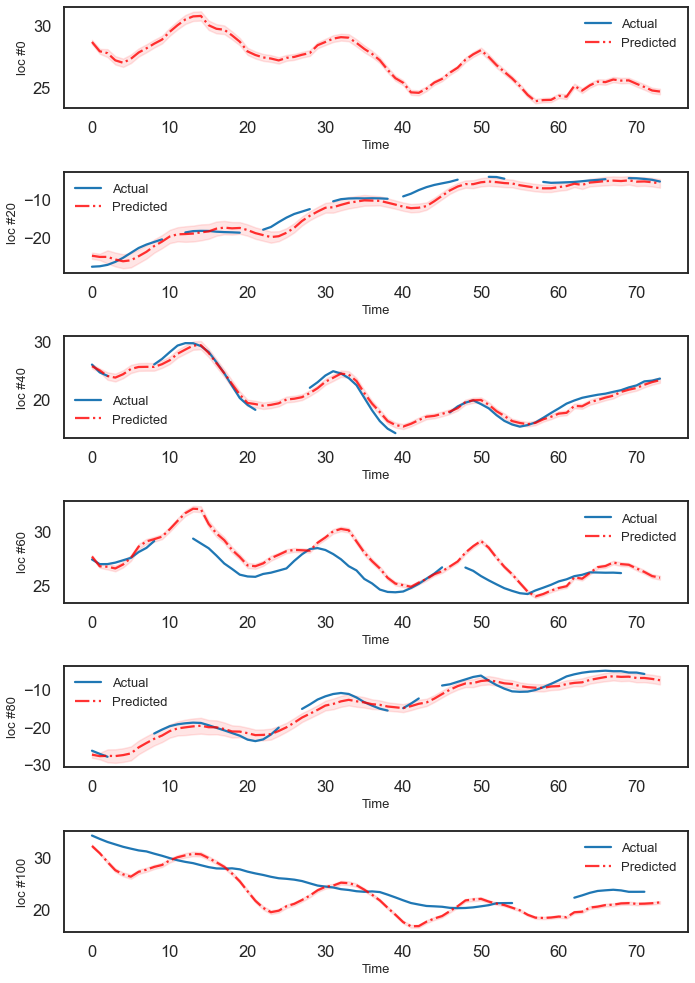

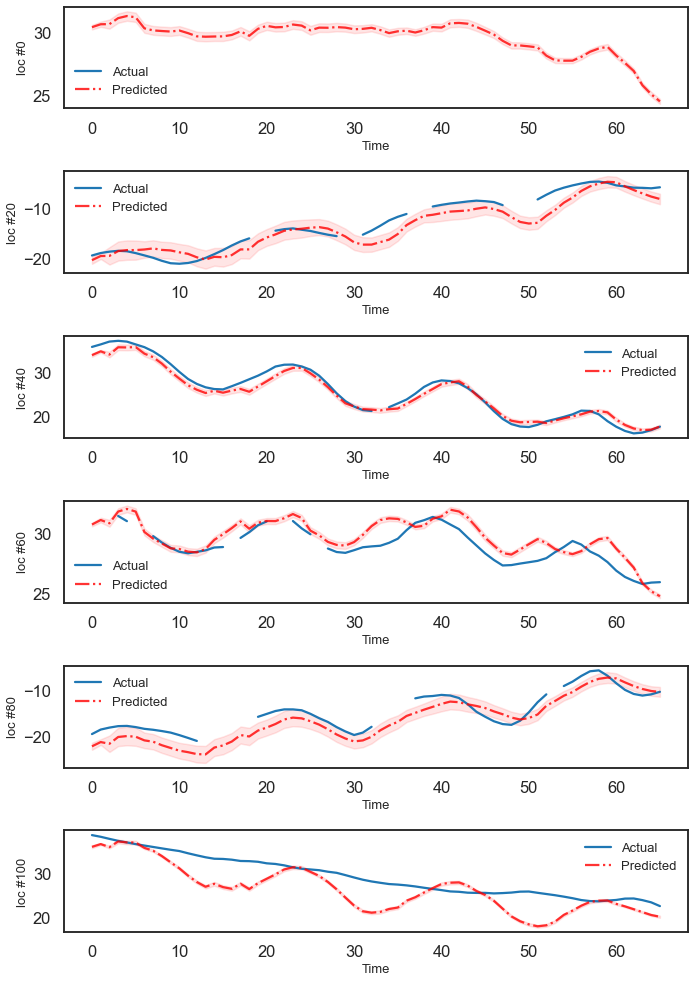

In [96]:
model_test.plot_predict(data_test)

## Example 2: Birmingham Parking Dataset
This dataset contains occupancy of $D=30$ car parks in Birmingham, UK, from October 4 to December 19,
2016 ($N=77$ days) every half an hour ($T=18$ time intervals per day) with 14.89% missing values. We picked the last 7 days for test and performed both short- and long-term forecasting.
### Short-term prediction

Using device: cpu
Total Number of Parameters: 30694
Learnable Parameters: 29434


  0%|          | 0/500 [00:00<?, ?it/s]

Using device: cpu, Epoch 500: {NRMSE_recv : 2.42, NRMSE_pred : 4.07}}}
Total Number of Parameters: 4297
Learnable Parameters: 2807


  0%|          | 0/500 [00:00<?, ?it/s]

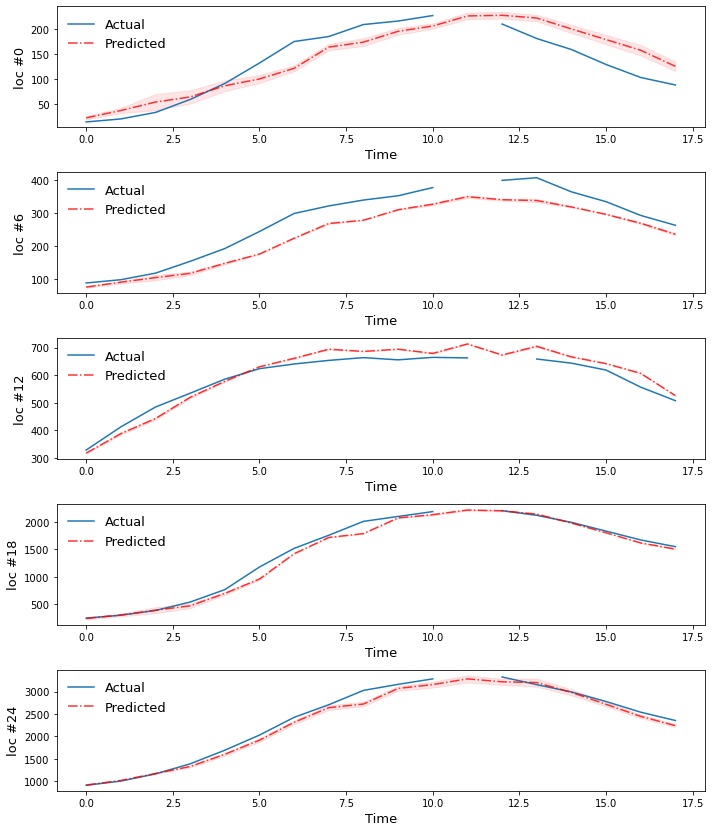

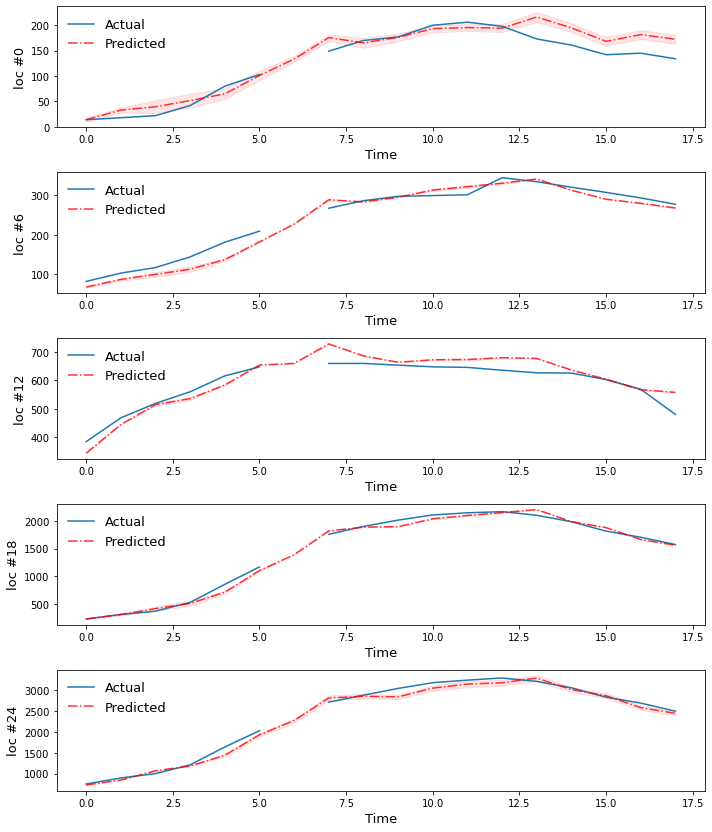

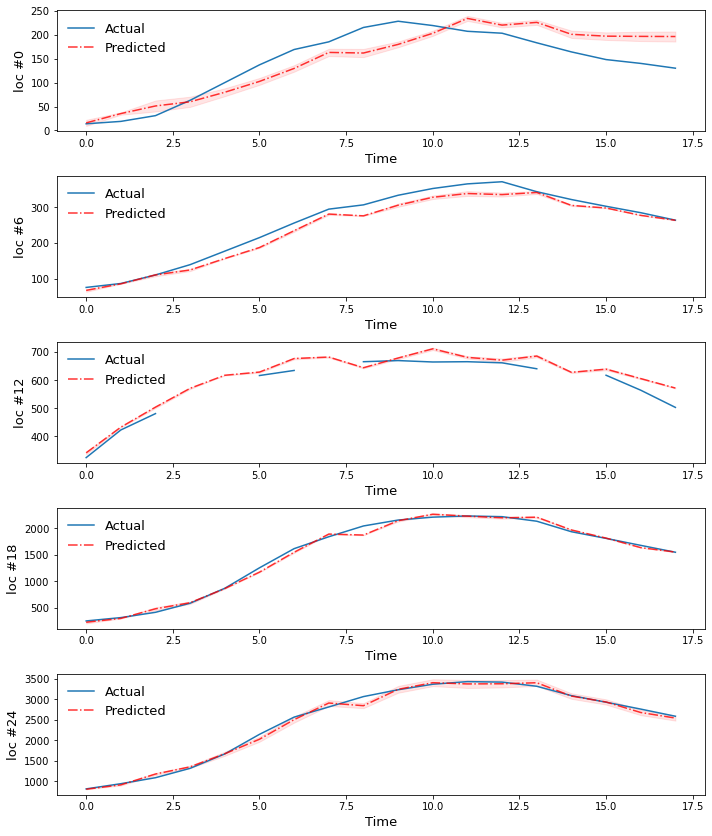

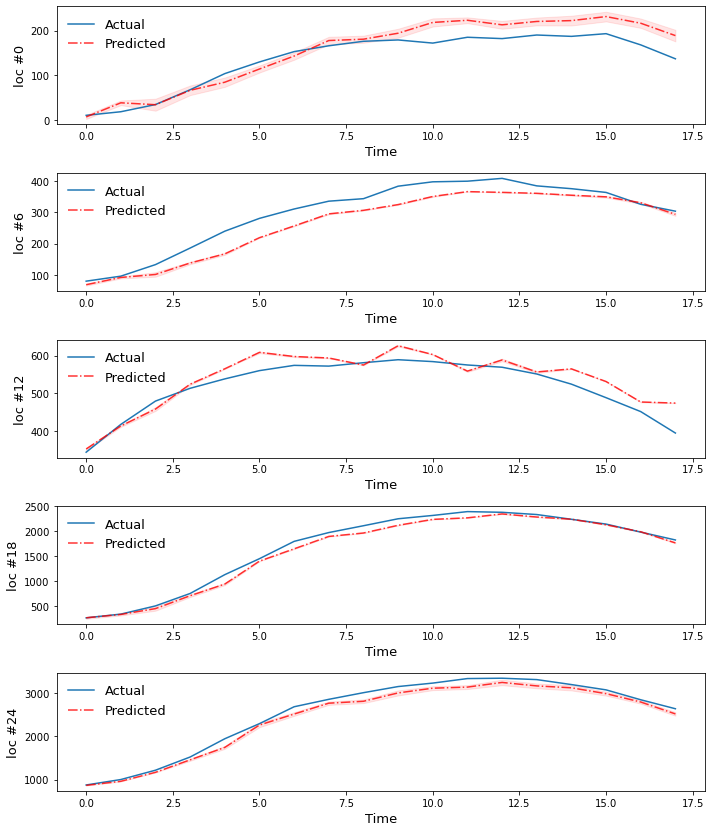

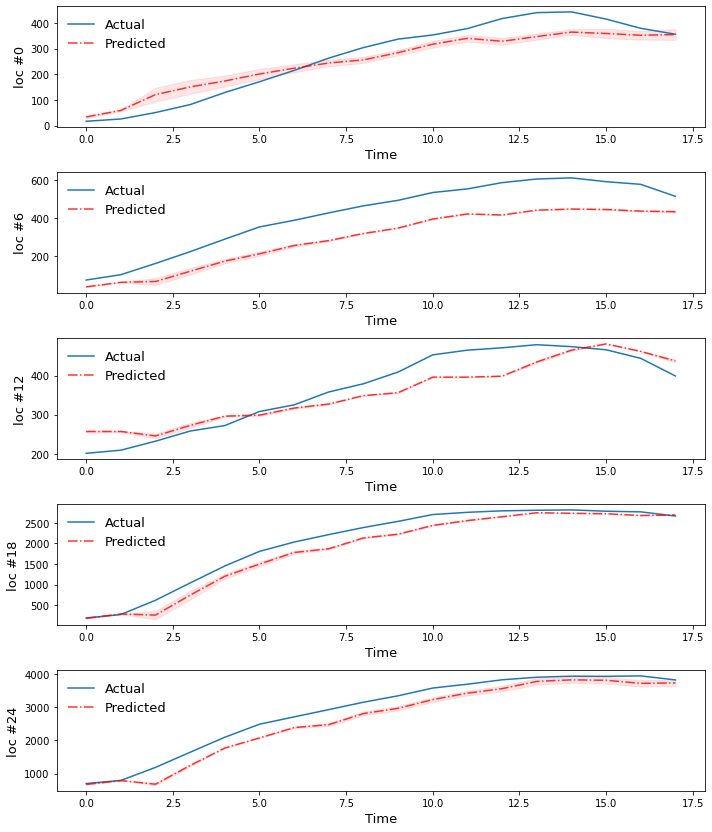

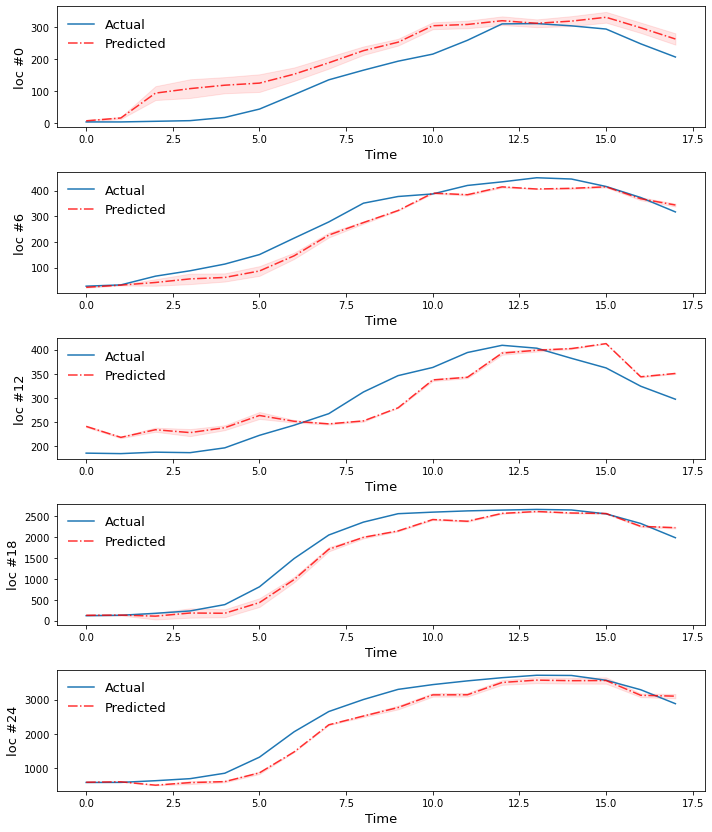

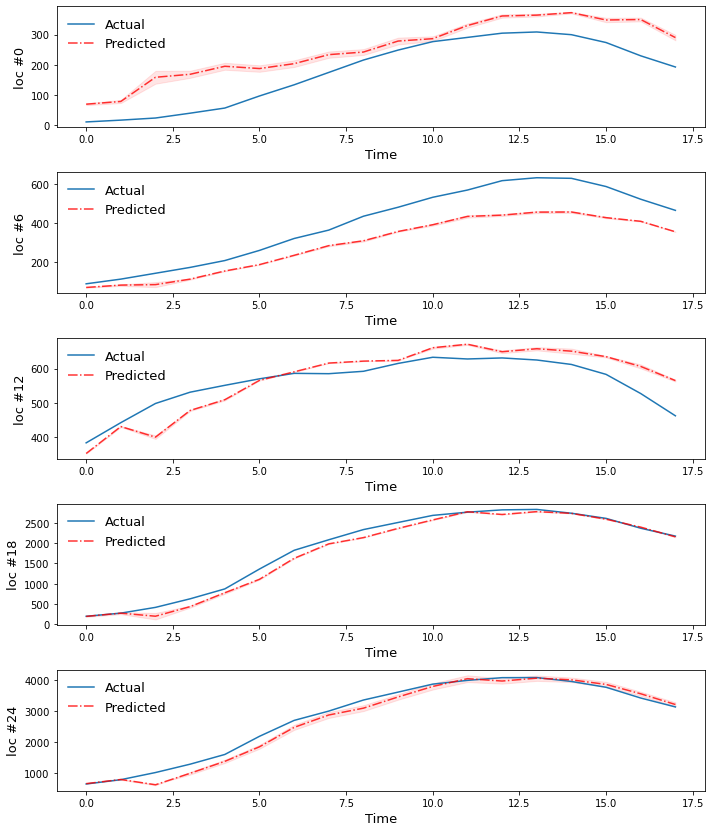

In [2]:
path = "./data/birmingham.mat"

from scipy.io import loadmat
data = loadmat(path)['tensor'].transpose(1,2,0).astype('float')
data[data == 0] = np.nan
D = data.shape[-1]

data_train = data[:-7]
data_test = data[-7:]
    
dsarf = DSARF(D, factor_dim =10, L=[1,2], S=1, batch_size=30)

model_train = dsarf.fit(data_train, 500)
model_test = dsarf.infer(data_test)
model_test.plot_predict(data_test)

### Long-term prediction

To perform long-term prediction (next 7 days) we consider temporal lags $L=[1,2,3,18,19,20,126,127,128]$ which corresponds to previous hour, day and week. We concatenate the dataset along time dimension to a tensor of size $1\times (N\times T) \times D$.

In [50]:
torch.manual_seed(10)
np.random.seed(10)

path = "./data/birmingham.mat"

from scipy.io import loadmat
data = loadmat(path)['tensor'].transpose(1,2,0).astype('float')
data[data == 0] = np.nan

D = data.shape[-1]
T = data.shape[1]
data = data.reshape(1,-1,D)
data_train = data[:,:-7*T]
data_test = data[:,-7*T:]
                
dsarf = DSARF(D, factor_dim =10, L=[1,2,3,18,19,20,126,127,128], S=2, batch_size=1)
model_train = dsarf.fit(data_train, 500)

Using device: cpu
Total Number of Parameters: 39781
Learnable Parameters: 37261


  0%|          | 0/500 [00:00<?, ?it/s]

Once the model is trained, we can use the built-in function `y_pred, y_pred_n, y_pred_p = model.long_predict(steps)` to predict the next `steps` time points. Additionally, we can simply visulize predicted vs groundtruth time series (for few instances and dimensions) by passing groundtruth data and prediction steps to the built-in function `model.plot_predict(data, steps)`.


Prediction NRMSE: 14.83


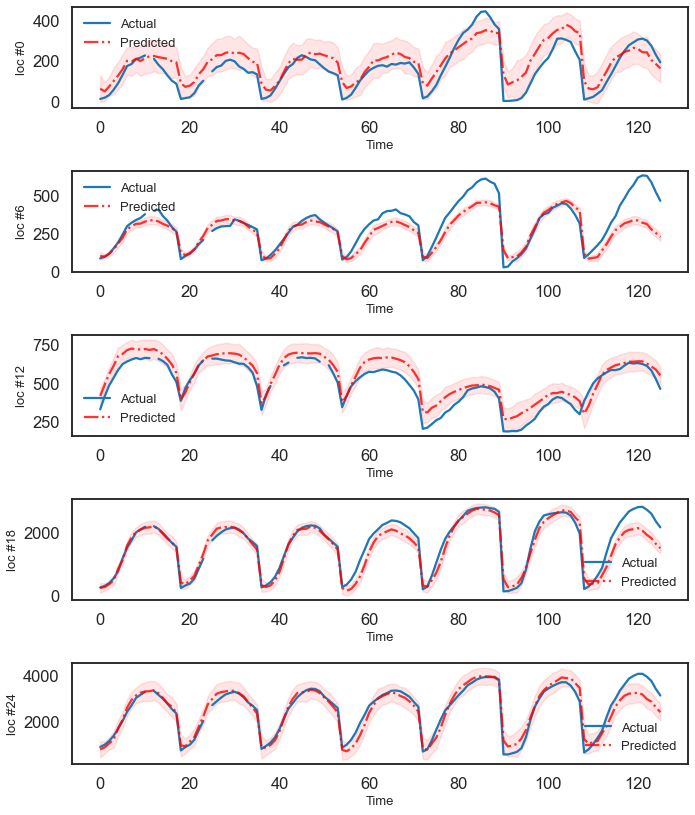

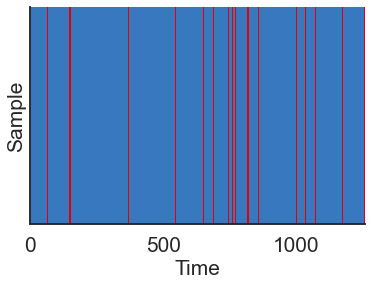

In [51]:
y_pred, _, _ = model_train.long_predict(steps = 7*T)
print('Prediction NRMSE: %.2f' %compute_NRMSE(data_test, y_pred))
model_train.plot_predict(data_test, steps = 7*T)
#model_train.plot_states()

## Example 3: Apnea Dataset

Using device: cpu
Total Number of Parameters: 4041
Learnable Parameters: 2041


  0%|          | 0/2000 [00:00<?, ?it/s]

Using device: cpu, Epoch 2000: {NRMSE_recv : 0.39, NRMSE_pred : 31.21}}}
Total Number of Parameters: 4041
Learnable Parameters: 2004


  0%|          | 0/500 [00:00<?, ?it/s]

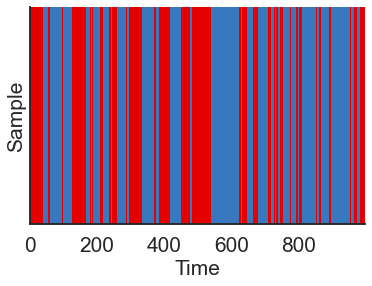

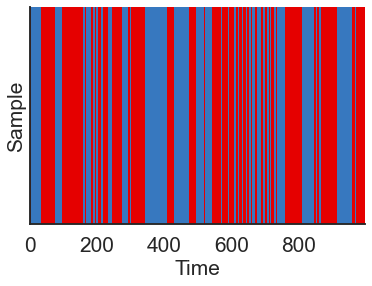

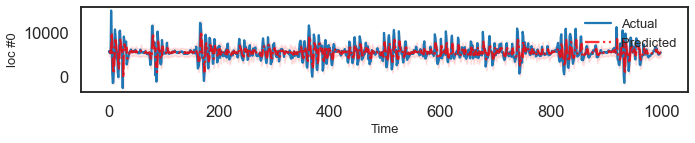

In [19]:
torch.manual_seed(10)
np.random.seed(10)

path = "./data/apnea.txt"

import pandas as pd
data = [pd.read_csv(path, sep=' ', header = None).values[6201:7201,1].reshape(-1,1),
            pd.read_csv(path, sep=' ', header = None).values[5201:6201,1].reshape(-1,1)]
data_train = data[:1]
data_test = data[1:]

D = 1

dsarf = DSARF(D, factor_dim = 1, L=[1], S=2, batch_size=1)

model_train = dsarf.fit(data_train, 2000)
model_test = dsarf.infer(data_test)
model_train.plot_states(k_smooth=7)
model_test.plot_states(k_smooth=7)
model_test.plot_predict(data_test)

## Example 4: Pendulum

Using device: cpu
Total Number of Parameters: 1327
Learnable Parameters: 917


  0%|          | 0/500 [00:00<?, ?it/s]

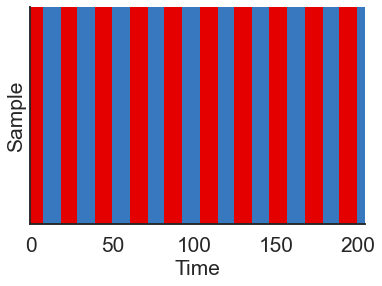

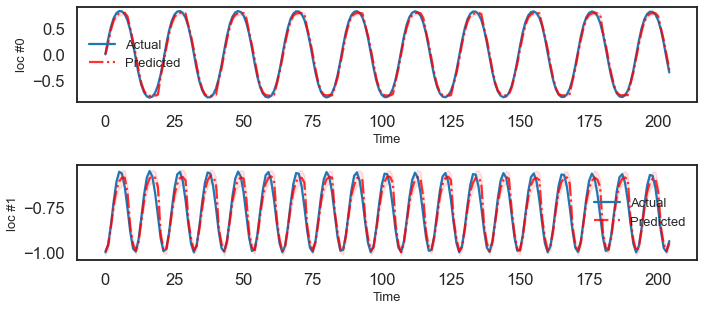

In [57]:
torch.manual_seed(15)
np.random.seed(15)

path = "./data/pendulum.npy"

data = [np.load(path)]
D = data[0].shape[-1]

dsarf = DSARF(D, factor_dim =2, L=[1], S=2, batch_size=1)

model_train = dsarf.fit(data, 500)
model_train.plot_states()
model_train.plot_predict(data)

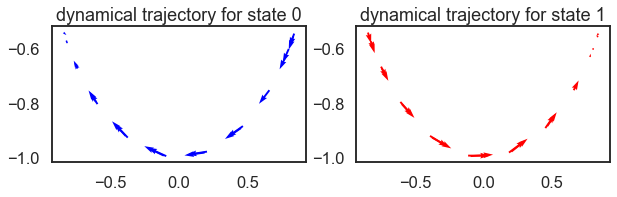

In [58]:
y_pred_0, _, _ = model_train.short_predict(s=0)
y_pred_1, _, _ = model_train.short_predict(s=1)
# we choose time points (5:25) to plot roughly one cycle
y_prev = data[0][4:24]
uv_0 = y_pred_0[0][5:25] - y_prev
uv_1 = y_pred_1[0][5:25] - y_prev
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,2.5))

ax = fig.add_subplot(121)
ax.quiver(y_prev[:,0], y_prev[:,1], uv_0[:,0], uv_0[:,1], color= 'b', angles='xy')
ax.set_title('dynamical trajectory for state 0')

ax = fig.add_subplot(122)
ax.quiver(y_prev[:,0], y_prev[:,1], uv_1[:,0], uv_1[:,1], color= 'r', angles='xy')
ax.set_title('dynamical trajectory for state 1')
plt.show()

## Example 5: Lorenz Attractor

Using device: cpu
Total Number of Parameters: 8240
Learnable Parameters: 6240


  0%|          | 0/1000 [00:00<?, ?it/s]

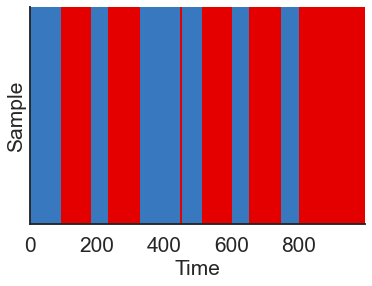

In [18]:
torch.manual_seed(10)
np.random.seed(10)

path = "./data/lorenz.json"

import json
f = open(path)
data = json.load(f)
D = len(data['data'][0][0])
data = np.array(data['data'])[:,2000:3000]

dsarf = DSARF(D, factor_dim =3, L=[1], S=2, batch_size=1, recurrent=True)

model_train = dsarf.fit(data, 1000)
model_train.plot_states()

## Example 6: Golf Dataset

Using device: cpu
Total Number of Parameters: 15155
Learnable Parameters: 11443


  0%|          | 0/300 [00:00<?, ?it/s]

Using device: cpu9, Epoch 300: {NRMSE_recv : 8.50, NRMSE_pred : 10.35}}
Total Number of Parameters: 1925
Learnable Parameters: 334


  0%|          | 0/500 [00:00<?, ?it/s]

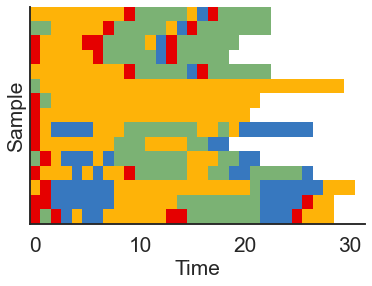

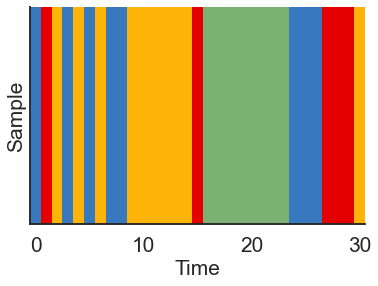

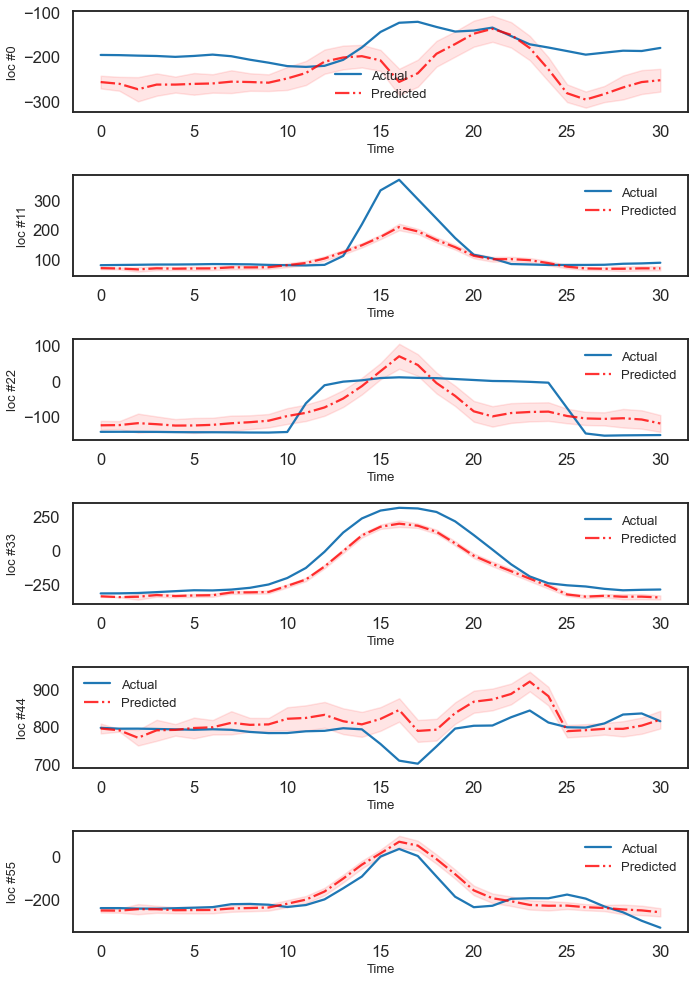

In [21]:
torch.manual_seed(10)
np.random.seed(10)

path = "./data/golf.json"

import json
f = open(path)
data = json.load(f)
D = len(data['joints']) * 3
data = [np.array(data[key]).reshape(-1, D)[::20]
           for key in list(data.keys())[1:]]
data_train = data[:-1]
data_test = data[-1:]

dsarf = DSARF(D, factor_dim =5, L=[1,2], S=4, batch_size=1)

model_train = dsarf.fit(data_train, 300)
model_test = dsarf.infer(data_test)
model_train.plot_states()
model_test.plot_states()
model_test.plot_predict(data_test)